In [30]:
from models.train_baseline import prepare_dataset
from models.train_baseline import split_dataset
from models.train_baseline import build_baseline_model
from models.train_baseline import build_tree_pipeline
from models.train_baseline import build_random_forest_pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve






In [2]:
X, y = prepare_dataset()

X.shape, y.shape

((7032, 19), (7032,))

In [3]:
X_train, X_test, y_train, y_test = split_dataset(X, y)

In [4]:
y_test.value_counts(normalize = True)

Churn Label
No     0.734186
Yes    0.265814
Name: proportion, dtype: float64

In [5]:
y_train.value_counts(normalize = True)

Churn Label
No     0.734222
Yes    0.265778
Name: proportion, dtype: float64

In [6]:
X_train.shape, X_test.shape

((5625, 19), (1407, 19))

In [7]:
from models.train_baseline import build_baseline_model

model = build_baseline_model(X_train)

model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [8]:
# Extract preprocessor and classifier
preprocessor = model.named_steps["preprocessor"]
classifier = model.named_steps["classifier"]

# Get Feature name after encoding 
feature_names = preprocessor.get_feature_names_out()

# Get coefficient 
coefficients = classifier.coef_[0]

len(feature_names), len(coefficients)

(46, 46)

In [9]:
import pandas as pd

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
})

coef_df["abs_coef"] = coef_df["coefficient"].abs()

coef_df_sorted = coef_df.sort_values(by="abs_coef", ascending=False)

coef_df_sorted.head(15)


,feature,coefficient,abs_coef
43,num__Tenure Months,-1.374763,1.374763
7,cat__Dependents_Yes,-0.980461,0.980461
36,cat__Contract_Two year,-0.757480,0.757480
6,cat__Dependents_No,0.645774,0.645774
45,num__Total Charges,0.643982,0.643982
34,cat__Contract_Month-to-month,0.611907,0.611907
13,cat__Internet Service_DSL,-0.544181,0.544181
14,cat__Internet Service_Fiber optic,0.469743,0.469743
44,num__Monthly Charges,-0.398325,0.398325
10,cat__Multiple Lines_No,-0.309413,0.309413


In [10]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

# prediction 
y_pred = model.predict(X_test)

# Probabilities (for RAC -  AUC)
y_proba = model.predict_proba(X_test)[:, 1]

In [11]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label = "Yes")
recall = recall_score(y_test, y_pred, pos_label="Yes")
f1 = f1_score(y_test, y_pred, pos_label = "Yes")
roc_auc = roc_auc_score((y_test == "Yes").astype(int), y_proba)

accuracy, precision, recall, f1, roc_auc

(0.8045486851457001,
 0.6410256410256411,
 0.6016042780748663,
 0.6206896551724138,
 0.8430548581308789)

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.86      0.88      0.87      1033
         Yes       0.64      0.60      0.62       374

    accuracy                           0.80      1407
   macro avg       0.75      0.74      0.74      1407
weighted avg       0.80      0.80      0.80      1407



In [13]:
import numpy as np 

# Try lower Threshold
threshold = 0.35

y_pred_adjusted = np.where(y_proba >= threshold, "Yes", "No")

precision_adj = precision_score(y_test, y_pred_adjusted, pos_label="Yes")
recall_adj = recall_score(y_test, y_pred_adjusted, pos_label="Yes")
f1_adj = f1_score(y_test, y_pred_adjusted, pos_label="Yes")

precision_adj, recall_adj, f1_adj

(0.5450901803607214, 0.7272727272727273, 0.6231386025200458)

In [14]:
tree_model = build_tree_pipeline(X_train)

tree_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [15]:
y_pred_tree = tree_model.predict(X_test)
y_proba_tree = tree_model.predict_proba(X_test)[:, 1]

accuracy_tree = accuracy_score(y_test, y_pred_tree)
precision_tree = precision_score(y_test, y_pred_tree, pos_label="Yes")
recall_tree = recall_score(y_test, y_pred_tree, pos_label="Yes")
roc_auc_tree = roc_auc_score((y_test == "Yes").astype(int), y_proba_tree)

accuracy_tree, precision_tree, recall_tree, roc_auc_tree

(0.7796730632551528,
 0.5714285714285714,
 0.6844919786096256,
 0.8347772181124496)

In [16]:
rf_model = build_random_forest_pipeline(X_train)

rf_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [18]:
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, pos_label="Yes")
recall_rf = recall_score(y_test, y_pred_rf, pos_label="Yes")
roc_auc_rf = roc_auc_score((y_test == "Yes").astype(int), y_proba_rf)

accuracy_rf, precision_rf, recall_rf, roc_auc_rf

(0.7995735607675906, 0.6564625850340136, 0.516042780748663, 0.8445509419115707)

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=["No", "Yes"])
cm

array([[907, 126],
       [149, 225]])

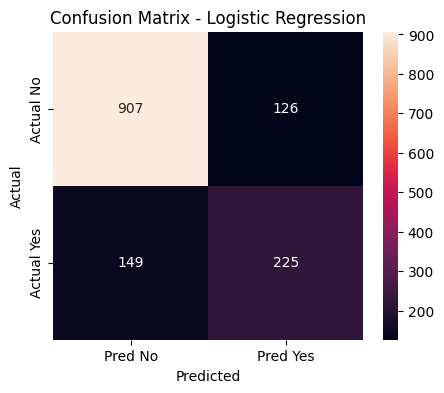

In [25]:
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=["Pred No", "Pred Yes"],
    yticklabels=["Actual No", "Actual Yes"]
)

plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

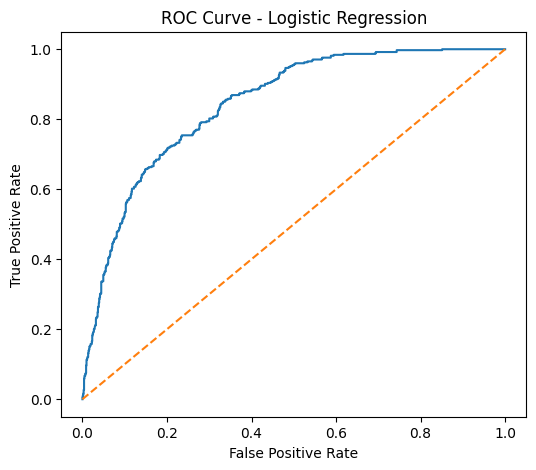

In [28]:
fpr, tpr, thresholds = roc_curve(
    (y_test == "Yes").astype(int),
    y_proba
)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.show()

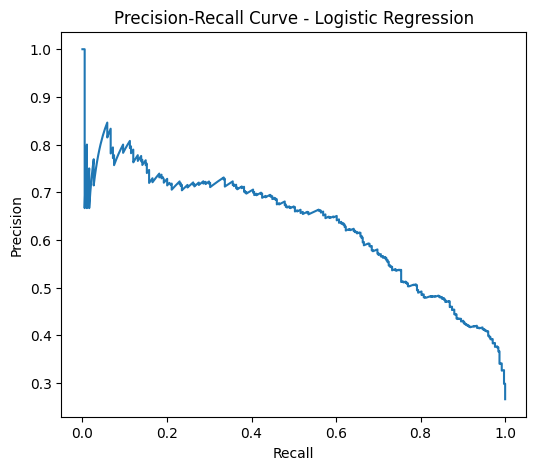

In [31]:
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(
    (y_test == "Yes").astype(int),
    y_proba
)

plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.show()

In [32]:
# Extract preprocessor and classifier from RF model
rf_preprocessor = rf_model.named_steps["preprocessor"]
rf_classifier = rf_model.named_steps["classifier"]

# Feature names after encoding
rf_feature_names = rf_preprocessor.get_feature_names_out()

# Feature importances
rf_importances = rf_classifier.feature_importances_

len(rf_feature_names), len(rf_importances)


(46, 46)

In [33]:
rf_importance_df = pd.DataFrame({
    "feature": rf_feature_names,
    "importance": rf_importances
})

rf_importance_df = rf_importance_df.sort_values(
    by="importance",
    ascending=False
)

rf_importance_df.head(15)


,feature,importance
34,cat__Contract_Month-to-month,0.132163
43,num__Tenure Months,0.131986
45,num__Total Charges,0.094086
14,cat__Internet Service_Fiber optic,0.066312
16,cat__Online Security_No,0.058315
44,num__Monthly Charges,0.052900
7,cat__Dependents_Yes,0.050766
25,cat__Tech Support_No,0.049320
36,cat__Contract_Two year,0.048048
6,cat__Dependents_No,0.038085
